# Perceptron

* Perceptron dates back to 1960s and considered first generation Neural Networks modeled after our brain cells.

* The Goal of Perceptron is to solve the problem of Classification where data $x \in \mathbb{R}^d$ and labels $y \in \{\pm 1\}$ by attempting to find a linear function $z$ such that

* $z = b + \sum w_{i}x_{i}$

* $y = 1$ if $z >= 0$ else
$y = 0$

# Multilayer Perceptron
* Perceptron can only solve linearly separable problems.

<center><img src="./assets/mlp_mnist.png" width=800></center>

# Multilayer Perceptron Example

MNIST dataset

* 70K grayscale images (28x28)
* Picture of a digit plus label

Let's download the data set           



In [1]:
import mxnet as mx
import numpy as np
import os, time, shutil
import zipfile, os
from gluoncv.utils import download

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs

mnist = mx.test_utils.get_mnist()

After running the above source code, the entire MNIST dataset should be fully loaded into memory. Note that for large datasets it is not feasible to pre-load the entire dataset first like we did here. What is needed is a mechanism by which we can quickly and efficiently stream data directly from the source. MXNet Data iterators come to the rescue here by providing exactly that. Data iterator is the mechanism by which we feed input data into an MXNet training algorithm and they are very simple to initialize and use and are optimized for speed. During training, we typically process training samples in small batches and over the entire training lifetime will end up processing each training example multiple times. In this tutorial, we'll configure the data iterator to feed examples in mini-batches of 100. Keep in mind that each example is a 28x28 grayscale image and the corresponding label.

Image batches are commonly represented by a 4-D array with shape `(batch_size, num_channels, width, height)`. For the MNIST dataset, since the images are grayscale, there is only one color channel. Also, the images are 28x28 pixels, and so each image has width and height equal to 28. Therefore, the shape of input is `(batch_size, 1, 28, 28)`. Another important consideration is the order of input samples. When feeding training examples, it is critical that we don't feed samples with the same label in succession. Doing so can slow down training.
Data iterators take care of this by randomly shuffling the inputs. Note that we only need to shuffle the training data. The order does not matter for test data.

The following source code initializes the data iterators for the MNIST dataset. Note that we initialize two iterators: one for train data and one for test data.

# Data

* Grayscale: one byte for color channel
* Input data is `(batch_size, 1, 28, 28)`
* Must shuffle training data with each epoch

## Dataset, DataLoader and Transforms
[Dataset](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.Dataset) - used to represent collection of data, includes methods to load/parse data on disk.  
[DataLoader](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.DataLoader) - mini-batches of data from Dataset, iterator interface, can load data in parallel.  
[Transforms](https://mxnet.incubator.apache.org/api/python/gluon/data.html#vision-transforms) - Transformations that can applied on data for augmentation, multiple transforms can composed to apply sequentially on the data. 

In [2]:
from multiprocessing import cpu_count

CPU_COUNT = cpu_count()

num_gpu_range = mx.test_utils.list_gpus()

ctx = [mx.gpu(i) for i in num_gpu_range] \
if num_gpu_range.stop > num_gpu_range.start else mx.cpu()


In [3]:
from mxnet import gluon
from mxnet.gluon.data.vision import transforms

batch_size = 100

train_dataset = gluon.data.vision.MNIST(train=True).transform_first(transforms.ToTensor())
train_data = gluon.data.DataLoader(train_dataset, 
                                   batch_size=batch_size,
                                   shuffle=True, num_workers=CPU_COUNT)

val_dataset = gluon.data.vision.MNIST(train=False).transform_first(transforms.ToTensor())
val_data = gluon.data.DataLoader(val_dataset, 
                                 batch_size=batch_size, num_workers=CPU_COUNT)

# Visualize the data

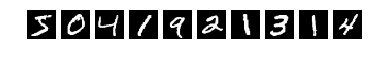

label: [5 0 4 1 9 2 1 3 1 4]


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(mnist['train_data'][i][0], cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (mnist['train_label'][0:10],))

### Define the network

The first approach makes use of a [Multilayer Perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) to solve this problem. We'll define the MLP using MXNet's imperative approach.

MLPs consist of several fully connected layers. A fully connected layer or FC layer for short, is one where each neuron in the layer is connected to every neuron in its preceding layer. From a linear algebra perspective, an FC layer applies an [affine transform](https://en.wikipedia.org/wiki/Affine_transformation) to the *n x m* input matrix *X* and outputs a matrix *Y* of size *n x k*, where *k* is the number of neurons in the FC layer. *k* is also referred to as the hidden size. The output *Y* is computed according to the equation *Y = W X + b*. The FC layer has two learnable parameters, the *m x k* weight matrix *W* and the *m x 1* bias vector *b*.

In an MLP, the outputs of most FC layers are fed into an activation function, which applies an element-wise non-linearity. This step is critical and it gives neural networks the ability to classify inputs that are not linearly separable. Common choices for activation functions are sigmoid, tanh, and [rectified linear unit](https://en.wikipedia.org/wiki/Rectifier_%28neural_networks%29) (ReLU). In this example, we'll use the ReLU activation function which has several desirable properties and is typically considered a default choice.

The following code declares three fully connected layers with 128, 64 and 10 neurons each.
The last fully connected layer often has its hidden size equal to the number of output classes in the dataset. Furthermore, these FC layers uses ReLU activation for performing an element-wise ReLU transformation on the FC layer output.

To do this, we will use [Sequential layer](http://mxnet.io/api/python/gluon/gluon.html#mxnet.gluon.nn.Sequential) type. This is simply a linear stack of neural network layers. `nn.Dense` layers are nothing but the fully connected layers we discussed above.

In [5]:
net = nn.Sequential()
with net.name_scope():
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(64, activation='relu'))
    net.add(nn.Dense(10))

# Initialize parameters and optimizer


The following source code initializes all parameters received from parameter dict using [Xavier](http://mxnet.io/api/python/optimization/optimization.html#mxnet.initializer.Xavier) initializer
to train the MLP network we defined above.

For our training, we will make use of the stochastic gradient descent (SGD) optimizer. In particular, we'll be using mini-batch SGD. Standard SGD processes train data one example at a time. In practice, this is very slow and one can speed up the process by processing examples in small batches. In this case, our batch size will be 100, which is a reasonable choice. Another parameter we select here is the learning rate, which controls the step size the optimizer takes in search of a solution. We'll pick a learning rate of 0.02, again a reasonable choice. Settings such as batch size and learning rate are what are usually referred to as hyper-parameters. What values we give them can have a great impact on training performance.

We will use [Trainer](http://mxnet.io/api/python/gluon/gluon.html#trainer) class to apply the
[SGD optimizer](http://mxnet.io/api/python/optimization/optimization.html#mxnet.optimizer.SGD) on the
initialized parameters.

In [6]:

net.initialize(mx.init.Xavier(), ctx=ctx)

trainer = gluon.Trainer(net.collect_params(),
                        'sgd',
                        {'learning_rate': 0.02})

# Train the network

In [7]:
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

In [8]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

## Training Loop

In [9]:
num_batch = len(train_data)
epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        # use gluon.utils.split_load to load a slice of the mini-batch to each context
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            # pass each slice of dadata to the network's forward pass and collect output            
            outputs = [net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        # for each loss, compute gradients            
        for l in loss:
            l.backward()
        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch
    
    _, val_acc = test(net, val_data, ctx)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

[Epoch 0] Train-acc: 0.797, loss: 0.782 | Val-acc: 0.898 | time: 3.8
[Epoch 1] Train-acc: 0.902, loss: 0.342 | Val-acc: 0.917 | time: 3.6
[Epoch 2] Train-acc: 0.918, loss: 0.286 | Val-acc: 0.928 | time: 3.7
[Epoch 3] Train-acc: 0.928, loss: 0.251 | Val-acc: 0.933 | time: 3.8
[Epoch 4] Train-acc: 0.937, loss: 0.225 | Val-acc: 0.938 | time: 3.7
[Epoch 5] Train-acc: 0.942, loss: 0.204 | Val-acc: 0.944 | time: 3.7
[Epoch 6] Train-acc: 0.947, loss: 0.187 | Val-acc: 0.949 | time: 3.7
[Epoch 7] Train-acc: 0.951, loss: 0.173 | Val-acc: 0.951 | time: 3.7
[Epoch 8] Train-acc: 0.955, loss: 0.160 | Val-acc: 0.954 | time: 3.7
[Epoch 9] Train-acc: 0.957, loss: 0.150 | Val-acc: 0.956 | time: 3.7


## Training and Validataion Loss/Accuracy 

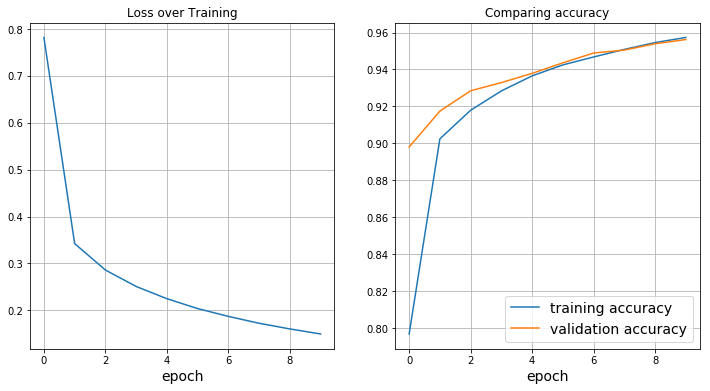

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(range(epochs), train_losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(range(epochs), train_accuracies)
p2, = fg2.plot(range(epochs), val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14) 

## Test Accuracy

In [11]:
_, test_acc = test(net, val_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.956


# Prediction

* Also called _Inference_
* Evaluate against unseen data
* Ensure model is not overfit
* We want models that generalize

# Sample predictions

prediction: 7, ground truth label: 7
prediction: 2, ground truth label: 2
prediction: 1, ground truth label: 1
prediction: 0, ground truth label: 0
prediction: 4, ground truth label: 4
prediction: 1, ground truth label: 1
prediction: 4, ground truth label: 4
prediction: 9, ground truth label: 9
prediction: 6, ground truth label: 5
prediction: 9, ground truth label: 9


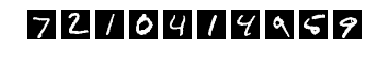

label: [7 2 1 0 4 1 4 9 5 9]


In [12]:
import numpy as np
for i in range(10):
    plt.subplot(1, 10, i+1)
    d = mnist['test_data'][i][0]
    x  = (mx.nd.expand_dims(mx.nd.array(d), axis=0))
    prediction = net(x.as_in_context(ctx[0]))
    prediction = np.squeeze(prediction.asnumpy())
    prediction = np.argmax(prediction)
    print('prediction: %s, ground truth label: %s' % (prediction, mnist['test_label'][i]))
    plt.imshow(d, cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % (mnist['test_label'][0:10],))

# Problems with MLP

MLP is not sufficient for more complex problems

* Sensitive to position within image.
* we don't exploit the spatial correlation in the image.
* Can end up with many parameters.
* Binary Threshold unit cannot tell if two single bit features are the same(think of an XOR).  
Positive cases (same): (1,1) -> 1; (0,0) -> 1  
Negative cases (different): (1,0) -> 0; (0,1) -> 0